## Trial

In [10]:
data_path = "C:/IIIT HYDERABAD/EXTRACTED FILE 1"

In [11]:
os.listdir(data_path)

['idd20kII', 'IDD_Segmentation']

In [16]:
ds_1 = os.path.join(data_path, os.listdir(data_path)[0])
ds_2 = os.path.join(data_path, os.listdir(data_path)[1])

In [17]:
ds_1, ds_2

('C:/IIIT HYDERABAD/EXTRACTED FILE 1\\idd20kII',
 'C:/IIIT HYDERABAD/EXTRACTED FILE 1\\IDD_Segmentation')

In [21]:
os.listdir(ds_1)

['gtFine', 'leftImg8bit']

In [22]:
import json

In [ ]:
uniq_ids = set()

with open("C:\\IIIT HYDERABAD\\EXTRACTED FILE 1\\IDD_Segmentation\\gtFine\\train\\178\\009462_gtFine_polygons.json") as file:
    data = json.load(file)
    id_list = [for _ in data['id']

## Dataset preprocessing done from cmd

## Model Training

In [2]:
# Run
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from pathlib import Path
from glob import glob
from sklearn.model_selection import train_test_split

In [3]:
# run
print(tf.__version__)

2.19.0


In [4]:
# run
image_dir = Path("C:/Users/SAKSHI/Modern_ML/AutoNUE_Project/public-code/domain_adaptation/source/source_datasets_dir/Mapillary/images")  # change path
mask_dir = Path("C:/Users/SAKSHI/Modern_ML/AutoNUE_Project/public-code/domain_adaptation/source/source_datasets_dir/Mapillary/labels")  # change path

# image_paths = sorted(glob(str(image_dir / ".jpg")))
# mask_paths = sorted(glob(str(mask_dir / ".png")))
image_paths = sorted(image_dir.glob("*.jpg"))
mask_paths = sorted(mask_dir.glob("*.png"))

image_paths = [str(p) for p in image_paths]
mask_paths = [str(p) for p in mask_paths]

In [5]:
# run
IMG_SIZE = (256, 256)
def process_path(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)/255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.cast(mask, tf.int32)
    mask = tf.where(mask == 255, 0, mask)

    return img, mask

# def get_dataset(image_paths, mask_paths, batch_size=16):
#     dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
#     dataset = dataset.map(lambda x,y: tf.py_function(process_path, [x,y], [tf.float32, tf.int32]), num_parallel_calls=tf.data.AUTOTUNE)
#     dataset = dataset.map(lambda x, y: (tf.reshape(x, [256, 256, 3]), tf.reshape(y, [256, 256, 1])))
#     dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
#     return dataset
def get_dataset(image_paths, mask_paths, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [6]:
# run
train_imgs, val_imgs, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

train_ds = get_dataset(train_imgs, train_masks)
val_ds = get_dataset(val_imgs, val_masks)

In [7]:
# run
from tensorflow.keras import layers, Model
def unet_model(input_shape=(256, 256, 3), num_classes=241):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    x1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x1 = layers.Conv2D(64, 3, activation='relu', padding='same')(x1)
    p1 = layers.MaxPooling2D()(x1)

    x2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    x2 = layers.Conv2D(128, 3, activation='relu', padding ='same')(x2)
    p2 = layers.MaxPooling2D()(x2)

    # bottleneck
    b = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    b = layers.Conv2D(256, 3, activation='relu', padding='same')(b)

    # Decoder
    u2 = layers.UpSampling2D()(b)
    u2 = layers.concatenate([u2, x2])
    x3 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    x3 = layers.Conv2D(128, 3, activation='relu', padding='same')(x3)

    u1 = layers.UpSampling2D()(x3)
    u1 = layers.concatenate([u1, x1])
    x4 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    x4 = layers.Conv2D(64, 3, activation='relu', padding='same')(x4)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(x4)
    return Model(inputs, outputs)

In [8]:
# run
model = unet_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
# run
from tensorflow import keras
model = keras.models.load_model('my_model.keras')

C:\Users\SAKSHI\Modern_ML\MML_VENV\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
# history = model.fit(train_ds, 
#                     validation_data=val_ds, 
#                     epochs=3, 
#                     verbose=1)

In [11]:
# for images, labels in train_ds.take(1):
#     print(tf.reduce_min(labels), tf.reduce_max(labels))

In [12]:
# model.save('my_model.keras')

In [13]:
# # run
# import matplotlib.pyplot as plt

# # Extract data
# acc = history.history.get('accuracy')
# val_acc = history.history.get('val_accuracy')
# loss = history.history.get('loss')
# val_loss = history.history.get('val_loss')
# epochs_range = range(len(acc))

# # Create plot
# plt.figure(figsize=(12, 5))

# # Accuracy
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()

# # Loss
# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.legend()

# plt.tight_layout()

# # ✅ Save to file
# plt.savefig('training_curves.png')  # or 'training_curves.pdf', etc.

# # Optionally show plot
# plt.show()


In [14]:
# run
def load_test_image(image_path, target_size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def load_test_mask(mask_path, target_size=(256, 256)):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, target_size, method='nearest')
    mask = tf.cast(mask, tf.int32)
    return mask


In [16]:
img1 = "C:/Users/SAKSHI/Modern_ML/AutoNUE_Project/Dataset/IDD_Segmentation/leftImg8bit/test/8/003236_leftImg8bit.png"  # change path
#img2 = "C:/Users/SAKSHI/Modern_ML/AutoNUE_Project/Dataset/Mapillary/testing/images/"C:/Users/SAKSHI/Modern_ML/AutoNUE_Project/Dataset/Mapillary/testing/images/_5yX5l4gpQ_pdLXhw2FPDQ.jpg"   
image = load_test_image(img1)  # shape: (H, W, 3)
input_tensor = tf.expand_dims(image, axis=0)  # shape: (1, H, W, 3)

prediction = model.predict(input_tensor)  # shape: (1, H, W, NUM_CLASSES)
pred_mask = tf.argmax(prediction, axis=-1)  # shape: (1, H, W)
pred_mask = pred_mask[0]  # shape: (H, W)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


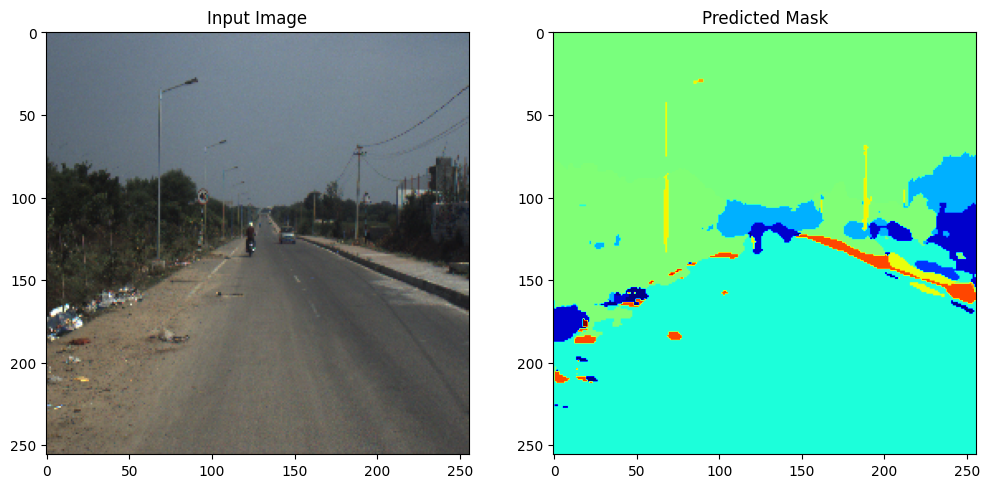

<Figure size 640x480 with 0 Axes>

In [17]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='jet')  # or use a color map that makes sense for your classes

plt.show()
plt.savefig('Input_Img_and_Training_Mask.png')

In [18]:
prediction = model.predict(input_tensor)          # shape: (1, H, W, NUM_CLASSES)
pred_mask = tf.argmax(prediction, axis=-1)[0]     # shape: (H, W)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


In [19]:
# class_names = ["road", "sidewalk", "building", ..., "sky"]  # 26 total
unique_classes = tf.unique(tf.reshape(pred_mask, [-1]))[0].numpy()

print("Classes present in this image:")
for c in unique_classes:
    print(f"Class: {c}")

Classes present in this image:
Class: 117
Class: 173
Class: 153
Class: 70
Class: 119
Class: 16
Class: 90
Class: 0
Class: 196
Class: 149
Class: 42
Class: 210
Class: 171
Class: 235


In [20]:
# Find the most frequent class in the predicted mask
import numpy as np
values, counts = np.unique(pred_mask.numpy(), return_counts=True)
dominant_class = values[np.argmax(counts)]

print(f"Dominant predicted class: {dominant_class}")

Dominant predicted class: 90
